# Deal with the image+slit files

In [1]:
from pathlib import Path
import warnings
import yaml
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from mes_longslit import regrid_images

## Regrid the images to a common frame, centered on the source

In [2]:
datapath = Path.cwd().parent / "data"
inpath =  datapath / "wcs"
outpath = datapath / "regrid"
outpath.mkdir(exist_ok=True)

We can use the database file that I wrote, so we can separate the Ha from O III exposures.

In [3]:
db = yaml.safe_load(
    (datapath / "image-slit-database.yml").read_text()
)
db

[{'image_id': 'N10035', 'line_id': 'Ha'},
 {'image_id': 'N10042', 'line_id': 'Ha'},
 {'image_id': 'N10047o', 'problem': 'Missing'},
 {'image_id': 'N20001', 'problem': 'Unfocused'},
 {'image_id': 'N20008', 'line_id': 'O III'},
 {'image_id': 'N20011', 'line_id': 'Ha'},
 {'image_id': 'spm0020o', 'line_id': 'Ha'},
 {'image_id': 'spm0025o', 'line_id': 'O III'},
 {'image_id': 'spm0047o', 'line_id': 'Ha'},
 {'image_id': 'spm0052o', 'line_id': 'O III'},
 {'image_id': 'spm0053o', 'line_id': 'Ha'},
 {'image_id': 'spm0058o', 'line_id': 'O III'},
 {'image_id': 'spm0109o', 'line_id': 'O III'},
 {'image_id': 'spm0210o', 'line_id': 'Ha'},
 {'image_id': 'spm0214o', 'line_id': 'Ha'},
 {'image_id': 'spm0431o', 'line_id': 'Ha'},
 {'image_id': 'spm0439o', 'line_id': 'Ha'},
 {'image_id': 'spm0600o', 'line_id': 'Ha'}]

In [4]:
ha_list = [_["image_id"] for _ in db if _.get("line_id") == "Ha"]
o3_list = [_["image_id"] for _ in db if _.get("line_id") == "O III"]

These are the coordinates of `PN Ou 5` [according to SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PN+Ou+5)

In [5]:
c0 = SkyCoord("21 14 20.03 +43 41 36.0", unit=(u.hourangle, u.deg))
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (318.58345833, 43.69333333)>

We only need a small image around the center, since it is a small nebula.  We take 400 pixel square with 0.2 arcsec per pixel, so 80 arcsec along each side. The smallest pixels in the original data are 0.35 arcsec, so we are oversampling enough to hopefully avoid any aliasing issues.

In [6]:
ha_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _id in ha_list:
        infile = inpath / f"cr{_id}_b-wcs.fits"
        hdulist = fits.open(infile)
        ha_dict[_id] = regrid_images(
            hdulist, 
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(400, 400),
        )    

In [7]:
ha_dict

{'N10035': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f930255bd30>],
 'N10042': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f9302698fd0>],
 'N20011': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f9302544580>],
 'spm0020o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92c040c940>],
 'spm0047o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93013a3a00>],
 'spm0053o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93013a3df0>],
 'spm0210o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92c040cd90>],
 'spm0214o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93026efe50>],
 'spm0431o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92f0470f40>],
 'spm0439o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92a00cbc10>],
 'spm0600o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93026fcfa0>]}

In [8]:
o3_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _id in o3_list:
        infile = inpath / f"cr{_id}_b-wcs.fits"
        hdulist = fits.open(infile)
        o3_dict[_id] = regrid_images(
            hdulist, 
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(400, 400),
        )  
o3_dict

{'N20008': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93013a3460>],
 'spm0025o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92a00cb460>],
 'spm0052o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f93026ed7f0>],
 'spm0058o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92e0e8ab50>],
 'spm0109o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f92f0468460>]}

Look at one of the results to make sure things are OK

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

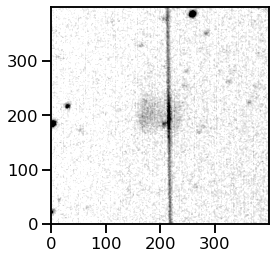

In [10]:
hdu = ha_dict["N20011"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(
    figsize=(4, 4),
#    subplot_kw=dict(projection=w)
)
ax.imshow(hdu.data, cmap="gray_r", origin="lower", vmin=-5, vmax=12)
# ax.set(
#     xlabel="RA",
#     ylabel="DEC",
# )

## Normalize the images

Define regions for normalizing the image.  Each window is 50x50 pixels
* `peak_window` is the central portion
* `bg_windows` is a list of the 4 corners

In [11]:
peak_window = slice(170, 230), slice(170, 230)
bg_windows = [
    (slice(None, 50), slice(None, 50)),
    (slice(-50, None), slice(None, 50)),
    (slice(None, 50), slice(-50, None)),
    (slice(-50, None), slice(-50, None)),    
]

def normalize(im):
    """Subtract background and divide by peak"""
    bg = np.mean(
        [np.median(im[window]) for window in bg_windows]
    )
    im_new = im - bg
    peak = np.median(im_new[peak_window])
    im_new /= peak
    return im_new

Apply the normalization to the Ha and [O III] images

In [12]:
for hdulist in ha_dict.values():
    hdulist[0].data = normalize(hdulist[0].data)

In [13]:
for hdulist in o3_dict.values():
    hdulist[0].data = normalize(hdulist[0].data)

Make median images:

In [14]:
ha_median = np.median(
    np.stack(
        [_[0].data for _ in ha_dict.values()],
    ),
    axis=0,
)
o3_median = np.median(
    np.stack(
        [_[0].data for _ in o3_dict.values()],
    ),
    axis=0,
)

Look at all the Ha images

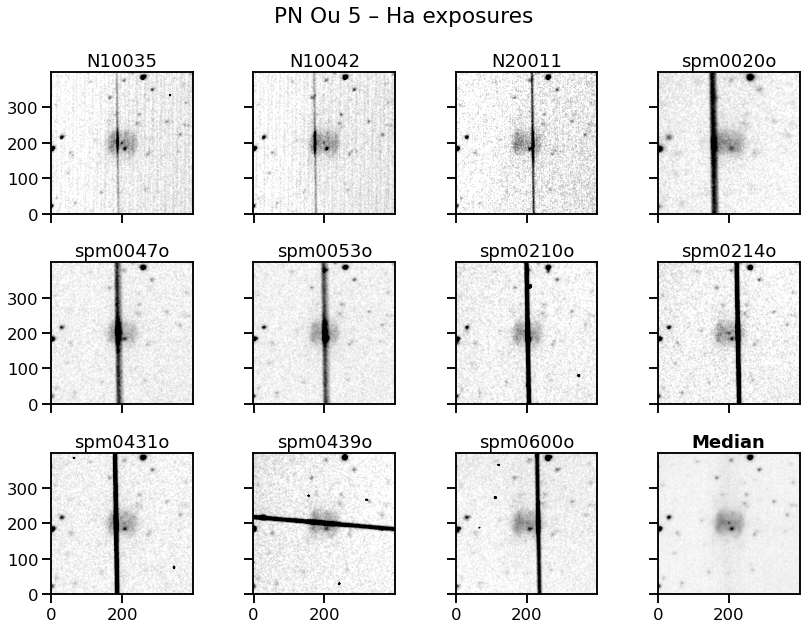

In [15]:
fig, axes = plt.subplots(
    3, 4, sharex=True, sharey=True,
    figsize=(12, 9),
)
for ax, (name, hdulist) in zip(axes.flat, ha_dict.items()):
    hdu = hdulist[0]
    ax.imshow(hdu.data, cmap="gray_r", origin="lower", vmin=-0.2, vmax=3.0)
    ax.set_title(name)
axes[-1, -1].imshow(ha_median, cmap="gray_r", origin="lower", vmin=-0.2, vmax=3.0)
axes[-1, -1].set_title("Median", fontweight="bold")
fig.suptitle("PN Ou 5 – Ha exposures")
fig.tight_layout()
fig.savefig("ha-image-slit-mosaic.pdf")

They all look good.  The slit is clearly narrower in the first 3 images.

Now write out the normalized images:

In [16]:
for name, hdulist in ha_dict.items():
    savefile = outpath / f"ha-imslit-{name}.fits"
    hdulist.writeto(savefile, overwrite=True)

# And the median image
savefile = outpath / f"ha-imslit-median.fits"
fits.PrimaryHDU(
    header=hdulist[0].header,
    data=ha_median,
).writeto(savefile, overwrite=True)

Repeat for [O III]

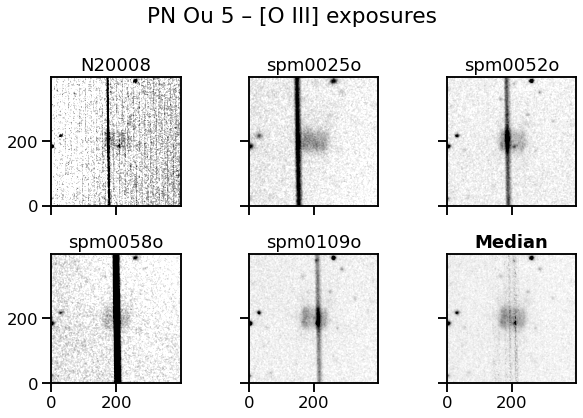

In [17]:
fig, axes = plt.subplots(
    2, 3, sharex=True, sharey=True,
    figsize=(9, 6),
)
for ax, (name, hdulist) in zip(axes.flat, o3_dict.items()):
    hdu = hdulist[0]
    ax.imshow(normalize(hdu.data), cmap="gray_r", origin="lower", vmin=-0.2, vmax=3.0)
    ax.set_title(name)
axes[-1, -1].imshow(o3_median, cmap="gray_r", origin="lower", vmin=-0.2, vmax=3.0)
axes[-1, -1].set_title("Median", fontweight="bold")
fig.suptitle("PN Ou 5 – [O III] exposures")
fig.tight_layout()
fig.savefig("o3-image-slit-mosaic.pdf")

In [18]:
for name, hdulist in o3_dict.items():
    savefile = outpath / f"o3-imslit-{name}.fits"
    hdulist.writeto(savefile, overwrite=True)
    
# And the median image
savefile = outpath / f"o3-imslit-median.fits"
fits.PrimaryHDU(
    header=hdulist[0].header,
    data=o3_median,
).writeto(savefile, overwrite=True)